# Object Detection with Street View House Numbers

This notebook illustrates how to build a deep CNN using Keras’ functional API to generate multiple outputs: one to predict how many digits are present, and five for the value of each in the order they appear.

## Imports & Settings

In [1]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, Activation

Using TensorFlow backend.


## Best Architecture

[Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks](https://arxiv.org/abs/1312.6082), Goodfellow, et al, 2014

- eight convolutional hidden layers, 
- one locally connected hidden layer
- two densely connected hidden layers. 
- the first hidden layer contains maxout units with three filters per unit
- the others contain rectifier units 
- the number of units is [48, 64, 128, 160] for the first four layers 
- 192 for all other locally connected layers
- the fully connected layers contain 3,072 units each. 
- Each convolutional layer includes max pooling and subtractive normalization
- The max pooling window size is 2 × 2. 
- The stride alternates between 2 and 1 at each layer, so that half of the layers don’t reduce the spatial size of the representation
- All convolutions use zero padding on the input to preserve representation size. 
- The subtractive normalization operates on 3x3 windows and preserves representation size. 
- All convolution kernels were of size 5 × 5. 
- We trained with dropout applied to all hidden layers but not the input.

The best-performing architecture on the original dataset has eight convolutional layers and two final fully-connected layers. The convolutional layers are similar so that we can define a function to simplify their creation:

In [2]:
def svhn_layer(model, filters, strides, n, input_shape=None):
    if input_shape is not None:
        model.add(Conv2D(filters, kernel_size=5, padding='same', name='CONV{}'.format(n), input_shape=input_shape))
    else:
        model.add(Conv2D(filters, kernel_size=5, padding='same', activation='relu', name='CONV{}'.format(n)))
    model.add(BatchNormalization(name='NORM{}'.format(n)))
    model.add(MaxPooling2D(pool_size=2, strides=strides, name='POOL{}'.format(n)))
    model.add(Dropout(0.2, name='DROP{}'.format(n)))
    return model

The entire model combines the Sequential and functional API as follows:

In [3]:
model = Sequential()

svhn_layer(model, 48, 1, n=1, input_shape=(32,32,1))

for i, kernel in enumerate([48, 64, 128, 160] + 3 * [192], 2):
    svhn_layer(model, kernel, strides=2 if i % 2 == 0 else 1, n=i)

model.add(Flatten())
model.add(Dense(3072, name='FC1'))
model.add(Dense(3072, name='FC2'))
y = model.output

n_digits = (Dense(units=6, activation='softmax'))(y)
digit1 = (Dense(units=10, activation='softmax'))(y)
digit2 = (Dense(units=11, activation='softmax'))(y)
digit3 = (Dense(units=11, activation='softmax'))(y)
digit4 = (Dense(units=11, activation='softmax'))(y)
digit5 = (Dense(units=11, activation='softmax'))(y)

svhn_model = Model(inputs=model.input, outputs=[n_digits, digit1, digit2, digit3, digit4, digit5])

As a result, the model produces six distinct outputs that we can evaluate.

In [4]:
svhn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CONV1_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (None, 32, 32, 48)   1248        CONV1_input[0][0]                
__________________________________________________________________________________________________
NORM1 (BatchNormalization)      (None, 32, 32, 48)   192         CONV1[0][0]                      
__________________________________________________________________________________________________
POOL1 (MaxPooling2D)            (None, 31, 31, 48)   0           NORM1[0][0]                      
__________________________________________________________________________________________________
DROP1 (Dro

### Get Data 

In [5]:
svhn_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=["accuracy"])

In [6]:
with pd.HDFStore('images/svhn/data.h5') as store:
    X_train = store['train/data'].values.reshape(-1, 32, 32, 1)
    y_train = store['train/labels']
    X_test = store['test/data'].values.reshape(-1, 32, 32, 1)
    y_test = store['test/labels']   

In [7]:
train_digits = [to_categorical(d) for d in y_train.values.T]
test_digits = [to_categorical(d) for d in y_test.values.T]

In [8]:
svhn_path = 'models/svhn.cnn.weights.best.hdf5'

In [9]:
checkpointer = ModelCheckpoint(filepath=svhn_path, 
                               verbose=1, 
                               save_best_only=True)

In [10]:
epochs = 25
result = svhn_model.fit(x=X_train,
                        y=train_digits,
                        batch_size=32,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, test_digits),
                        callbacks=[checkpointer])

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 33401 samples, validate on 13068 samples
Epoch 1/25
33401/33401 [==============================] - 314s 9ms/step - loss: 9.7087 - dense_1_loss: 1.5593 - dense_2_loss: 3.0150 - dense_3_loss: 3.1225 - dense_4_loss: 1.5303 - dense_5_loss: 0.4141 - dense_6_loss: 0.0675 - dense_1_acc: 0.6416 - dense_2_acc: 0.2507 - dense_3_acc: 0.1959 - dense_4_acc: 0.6649 - dense_5_acc: 0.9424 - dense_6_acc: 0.9931 - val_loss: 7.5946 - val_dense_1_loss: 1.0219 - val_dense_2_loss: 3.0613 - val_dense_3_loss: 2.4888 - val_dense_4_loss: 0.8573 - val_dense_5_loss: 0.1596 - val_dense_6_loss: 0.0057 - val_dense_1_acc: 0.7795 - val_dense_2_acc: 0.1369 - val_dense_3_acc: 0.2273 - val_dense_4_acc: 0.7792 - val_dense_5_acc: 0.9887 - val_dense_6_acc: 0.9998

Epoch 00001: val_loss improved from inf to 7.59463, saving model to models/svhn.cnn.weights.best.hdf5
Epoch 2/25
33401/33401 [==============================] - 347s 10ms/step - loss: 10.0200 - dense_1_loss: 1.5287 - dense_2_loss: 2.9456 - dense_3_loss: 3.


Epoch 00011: val_loss did not improve from 5.75069
Epoch 12/25
33401/33401 [==============================] - 299s 9ms/step - loss: 8.7124 - dense_1_loss: 1.3090 - dense_2_loss: 2.6156 - dense_3_loss: 2.8611 - dense_4_loss: 1.5322 - dense_5_loss: 0.3541 - dense_6_loss: 0.0404 - dense_1_acc: 0.6048 - dense_2_acc: 0.2486 - dense_3_acc: 0.1979 - dense_4_acc: 0.6781 - dense_5_acc: 0.9508 - dense_6_acc: 0.9959 - val_loss: 5.8453 - val_dense_1_loss: 0.6830 - val_dense_2_loss: 2.1058 - val_dense_3_loss: 2.2155 - val_dense_4_loss: 0.7460 - val_dense_5_loss: 0.0926 - val_dense_6_loss: 0.0025 - val_dense_1_acc: 0.7609 - val_dense_2_acc: 0.2356 - val_dense_3_acc: 0.2804 - val_dense_4_acc: 0.8299 - val_dense_5_acc: 0.9886 - val_dense_6_acc: 0.9998

Epoch 00012: val_loss did not improve from 5.75069
Epoch 13/25
33401/33401 [==============================] - 300s 9ms/step - loss: 7.7992 - dense_1_loss: 1.1011 - dense_2_loss: 2.4061 - dense_3_loss: 2.6669 - dense_4_loss: 1.3306 - dense_5_loss: 0.288

In [11]:
n_digits, digit1, digit2, digit3, digit4, digit5 = svhn_model.predict(X_test, verbose=1)

13068/13068 [==============================] - 33s 3ms/step


In [12]:
(y_test[0] == np.argmax(n_digits, axis=1)).sum()/len(n_digits)

0.9206458524640343

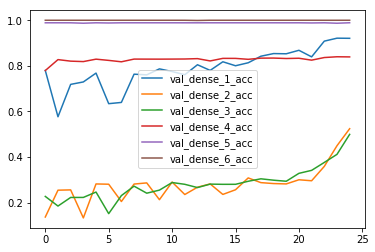

In [22]:
pd.DataFrame(result.history)[['val_dense_{}_acc'.format(i) for i in range(1, 7)]].plot();

In [23]:
confusion_matrix(y_true=y_test[0], y_pred=np.argmax(n_digits, axis=1))

array([[2363,  104,   12,    4,    0],
       [ 183, 7605,  568,    0,    0],
       [  20,   55, 2000,    6,    0],
       [   0,    0,   83,   63,    0],
       [   0,    0,    1,    1,    0]])

In [24]:
confusion_matrix(y_true=y_test[1], y_pred=np.argmax(digit1, axis=1))

array([[   0,   14,    1,    1,    0,    0,    3,    0,    0,    0],
       [   0, 3542,  100,    3,   23,    1,   13,   12,    0,    0],
       [   0,  134, 2137,  222,   15,   20,   30,   97,    2,    0],
       [   0,  112, 1029,  250,   33,  121,   39,   36,    5,    0],
       [   0,  851,   91,    3,  239,    1,   20,   31,    0,    0],
       [   0,   45,  481,  276,    2,  145,   65,   13,   25,    0],
       [   0,  226,   89,   43,   70,   26,  354,   34,   11,    4],
       [   0,  202,  335,   17,   21,    3,   18,  150,    1,    0],
       [   0,   98,  126,   78,   21,   55,  189,   20,   34,    4],
       [   0,   70,  216,   73,   12,   75,   64,   24,   22,    0]])

In [23]:
pd.Series(np.argmax(digit1, axis=1)).value_counts()

1    12704
7      302
2       55
3        7
dtype: int64

In [18]:
y_test[0].value_counts(normalize=True)

2    0.639425
1    0.190006
3    0.159244
4    0.011172
5    0.000153
Name: 0, dtype: float64